# Combine LSTM and VAR for Multivariate Time Series Forecasting

Marco Cerliani. [Reference](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b). [Data](https://archive.ics.uci.edu/ml/datasets/Air+Quality)

`A multiple-steps training process application in Time Series Forecasting domain`

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.vector_ar.var_model import VAR

register_matplotlib_converters()

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline

## THE DATA

The data for our experiment contains hourly averaged responses from metal oxide chemical sensors embedded in an Air Quality Multisensor Device, located on the field in a significantly polluted area of an Italian city. Data were recorded for one year and contains ground truth hourly averaged concentrations for CO, Non-Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2). Also, external variables are provided like weather conditions. A good amount of NaNs are present, so a linear interpolation is required before proceeding (series with more than 50% of NaNs in train data are excluded).

In [2]:
df = pd.read_csv('.\\data\\AirQualityUCI.csv', sep=';', parse_dates={'date':['Date', 'Time']})
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 16 columns):
date             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(2), int64(8), object(6)
memory usage: 1.1+ MB


date CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004 18.00.00    2,6         1360       150     11,9           1046   
1  10/03/2004 19.00.00      2         1292       112      9,4            955   
2  10/03/2004 20.00.00    2,2         1402        88      9,0            939   
3  10/03/2004 21.00.00    2,2         1376        80      9,2            948   
4  10/03/2004 22.00.00    1,6         1272        51      6,5            836   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0      166          1056      113          1692         1268  13,6  48,9   
1      103          1174       92          1559          972  13,3  47,7   
2      131          1140      114          1555         1074  11,9  54,0   
3      172          1092      122          1584         1203  11,0  60,0   
4      131          1205      116          1490         1110  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

In [3]:
df.dropna(axis=1, inplace=True, how='all')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
date             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
dtypes: int64(8), object(6)
memory usage: 1023.5+ KB


date CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004 18.00.00    2,6         1360       150     11,9           1046   
1  10/03/2004 19.00.00      2         1292       112      9,4            955   
2  10/03/2004 20.00.00    2,2         1402        88      9,0            939   
3  10/03/2004 21.00.00    2,2         1376        80      9,2            948   
4  10/03/2004 22.00.00    1,6         1272        51      6,5            836   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0      166          1056      113          1692         1268  13,6  48,9   
1      103          1174       92          1559          972  13,3  47,7   
2      131          1140      114          1555         1074  11,9  54,0   
3      172          1092      122          1584         1203  11,0  60,0   
4      131          1205      116          1490         1110  11,2  59,6   

       AH  
0  0,7578  
1  0,7255  
2  0,7502  
3  0,7867  
4  0,7888

In [4]:
df.dropna(inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
date             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
dtypes: int64(8), object(6)
memory usage: 1.1+ MB


date CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004 18.00.00    2,6         1360       150     11,9           1046   
1  10/03/2004 19.00.00      2         1292       112      9,4            955   
2  10/03/2004 20.00.00    2,2         1402        88      9,0            939   
3  10/03/2004 21.00.00    2,2         1376        80      9,2            948   
4  10/03/2004 22.00.00    1,6         1272        51      6,5            836   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0      166          1056      113          1692         1268  13,6  48,9   
1      103          1174       92          1559          972  13,3  47,7   
2      131          1140      114          1555         1074  11,9  54,0   
3      172          1092      122          1584         1203  11,0  60,0   
4      131          1205      116          1490         1110  11,2  59,6   

       AH  
0  0,7578  
1  0,7255  
2  0,7502  
3  0,7867  
4  0,7888

In [5]:
df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
date = df['date'].values
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
dtypes: int64(8), object(5)
memory usage: 1023.4+ KB


CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
date                                                                        
2004-03-10 18:00:00    2,6         1360       150     11,9           1046   
2004-03-10 19:00:00      2         1292       112      9,4            955   
2004-03-10 20:00:00    2,2         1402        88      9,0            939   
2004-03-10 21:00:00    2,2         1376        80      9,2            948   
2004-03-10 22:00:00    1,6         1272        51      6,5            836   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
date                                                                
2004-03-10 18:00:00      166          1056      113          1692   
2004-03-10 19:00:00      103          1174       92          1559   
2004-03-10 20:00:00      131          1140      114          1555   
2004-03-10 21:00:00      172          1092      122          1584   
2004-03-10 22:00:00      131          1205      116          1490   

                     PT08.S5(O3)     T    RH      AH  
date                                                  
2004-03-10 18:00:00         1268  13,6  48,9  0,7578  
2004-03-10 19:00:00          972  13,3  47,7  0,7255  
2004-03-10 20:00:00         1074  11,9  54,0  0,7502  
2004-03-10 21:00:00         1203  11,0  60,0  0,7867  
2004-03-10 22:00:00         1110  11,2  59,6  0,7888

In [6]:
date

array(['2004-03-10T18:00:00.000000000', '2004-03-10T19:00:00.000000000',
       '2004-03-10T20:00:00.000000000', ...,
       '2005-04-04T12:00:00.000000000', '2005-04-04T13:00:00.000000000',
       '2005-04-04T14:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
df.columns = [col.split('(')[0] for col in df.columns]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
CO         9357 non-null object
PT08.S1    9357 non-null int64
NMHC       9357 non-null int64
C6H6       9357 non-null object
PT08.S2    9357 non-null int64
NOx        9357 non-null int64
PT08.S3    9357 non-null int64
NO2        9357 non-null int64
PT08.S4    9357 non-null int64
PT08.S5    9357 non-null int64
T          9357 non-null object
RH         9357 non-null object
AH         9357 non-null object
dtypes: int64(8), object(5)
memory usage: 1023.4+ KB


CO  PT08.S1  NMHC  C6H6  PT08.S2  NOx  PT08.S3  NO2  \
date                                                                        
2004-03-10 18:00:00  2,6     1360   150  11,9     1046  166     1056  113   
2004-03-10 19:00:00    2     1292   112   9,4      955  103     1174   92   
2004-03-10 20:00:00  2,2     1402    88   9,0      939  131     1140  114   
2004-03-10 21:00:00  2,2     1376    80   9,2      948  172     1092  122   
2004-03-10 22:00:00  1,6     1272    51   6,5      836  131     1205  116   

                     PT08.S4  PT08.S5     T    RH      AH  
date                                                       
2004-03-10 18:00:00     1692     1268  13,6  48,9  0,7578  
2004-03-10 19:00:00     1559      972  13,3  47,7  0,7255  
2004-03-10 20:00:00     1555     1074  11,9  54,0  0,7502  
2004-03-10 21:00:00     1584     1203  11,0  60,0  0,7867  
2004-03-10 22:00:00     1490     1110  11,2  59,6  0,7888

In [8]:
print(df.shape)
df.head()

(9357, 13)


CO  PT08.S1  NMHC  C6H6  PT08.S2  NOx  PT08.S3  NO2  \
date                                                                        
2004-03-10 18:00:00  2,6     1360   150  11,9     1046  166     1056  113   
2004-03-10 19:00:00    2     1292   112   9,4      955  103     1174   92   
2004-03-10 20:00:00  2,2     1402    88   9,0      939  131     1140  114   
2004-03-10 21:00:00  2,2     1376    80   9,2      948  172     1092  122   
2004-03-10 22:00:00  1,6     1272    51   6,5      836  131     1205  116   

                     PT08.S4  PT08.S5     T    RH      AH  
date                                                       
2004-03-10 18:00:00     1692     1268  13,6  48,9  0,7578  
2004-03-10 19:00:00     1559      972  13,3  47,7  0,7255  
2004-03-10 20:00:00     1555     1074  11,9  54,0  0,7502  
2004-03-10 21:00:00     1584     1203  11,0  60,0  0,7867  
2004-03-10 22:00:00     1490     1110  11,2  59,6  0,7888

In [9]:
### ADJUST AND CLEAN DATA ###
df_external = pd.DataFrame(df.index)
df_external

date
0    2004-03-10 18:00:00
1    2004-03-10 19:00:00
2    2004-03-10 20:00:00
3    2004-03-10 21:00:00
4    2004-03-10 22:00:00
...                  ...
9352 2005-04-04 10:00:00
9353 2005-04-04 11:00:00
9354 2005-04-04 12:00:00
9355 2005-04-04 13:00:00
9356 2005-04-04 14:00:00

[9357 rows x 1 columns]

In [10]:
for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ': ', df[col].isna().sum()/len(df))
    
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: 
        # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)
df.head()

CO :  17.986534145559474
PT08.S1 :  3.9115100993908305
NMHC :  90.23191193758683
C6H6 :  3.9115100993908305
PT08.S2 :  3.9115100993908305
NOx :  17.51629795874746
PT08.S3 :  3.9115100993908305
NO2 :  17.54835951693919
PT08.S4 :  3.9115100993908305
PT08.S5 :  3.9115100993908305
T :  3.9115100993908305
RH :  3.9115100993908305
AH :  3.9115100993908305


CO  PT08.S1  C6H6  PT08.S2    NOx  PT08.S3    NO2  \
date                                                                      
2004-03-10 18:00:00  2.6   1360.0  11.9   1046.0  166.0   1056.0  113.0   
2004-03-10 19:00:00  2.0   1292.0   9.4    955.0  103.0   1174.0   92.0   
2004-03-10 20:00:00  2.2   1402.0   9.0    939.0  131.0   1140.0  114.0   
2004-03-10 21:00:00  2.2   1376.0   9.2    948.0  172.0   1092.0  122.0   
2004-03-10 22:00:00  1.6   1272.0   6.5    836.0  131.0   1205.0  116.0   

                     PT08.S4  PT08.S5  
date                                   
2004-03-10 18:00:00   1692.0   1268.0  
2004-03-10 19:00:00   1559.0    972.0  
2004-03-10 20:00:00   1555.0   1074.0  
2004-03-10 21:00:00   1584.0   1203.0  
2004-03-10 22:00:00   1490.0   1110.0

In [11]:
df_external

date     T    RH      AH
0    2004-03-10 18:00:00  13.6  48.9  0.7578
1    2004-03-10 19:00:00  13.3  47.7  0.7255
2    2004-03-10 20:00:00  11.9  54.0  0.7502
3    2004-03-10 21:00:00  11.0  60.0  0.7867
4    2004-03-10 22:00:00  11.2  59.6  0.7888
...                  ...   ...   ...     ...
9352 2005-04-04 10:00:00  21.9  29.3  0.7568
9353 2005-04-04 11:00:00  24.3  23.7  0.7119
9354 2005-04-04 12:00:00  26.9  18.3  0.6406
9355 2005-04-04 13:00:00  28.3  13.5  0.5139
9356 2005-04-04 14:00:00  28.5  13.1  0.5028

[9357 rows x 4 columns]

In [12]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [13]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###
df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour
df_external

In [15]:
df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)
df_external

T    RH      AH  month_sin     month_cos   day_sin  \
date                                                                         
2004-03-10 18:00:00  13.6  48.9  0.7578   1.000000  6.123234e-17  0.866025   
2004-03-10 19:00:00  13.3  47.7  0.7255   1.000000  6.123234e-17  0.866025   
2004-03-10 20:00:00  11.9  54.0  0.7502   1.000000  6.123234e-17  0.866025   
2004-03-10 21:00:00  11.0  60.0  0.7867   1.000000  6.123234e-17  0.866025   
2004-03-10 22:00:00  11.2  59.6  0.7888   1.000000  6.123234e-17  0.866025   
...                   ...   ...     ...        ...           ...       ...   
2005-04-04 10:00:00  21.9  29.3  0.7568   0.866025 -5.000000e-01  0.000000   
2005-04-04 11:00:00  24.3  23.7  0.7119   0.866025 -5.000000e-01  0.000000   
2005-04-04 12:00:00  26.9  18.3  0.6406   0.866025 -5.000000e-01  0.000000   
2005-04-04 13:00:00  28.3  13.5  0.5139   0.866025 -5.000000e-01  0.000000   
2005-04-04 14:00:00  28.5  13.1  0.5028   0.866025 -5.000000e-01  0.000000   

                     day_cos  hour_sin  hour_cos  
date                                              
2004-03-10 18:00:00     -0.5 -0.979084  0.203456  
2004-03-10 19:00:00     -0.5 -0.887885  0.460065  
2004-03-10 20:00:00     -0.5 -0.730836  0.682553  
2004-03-10 21:00:00     -0.5 -0.519584  0.854419  
2004-03-10 22:00:00     -0.5 -0.269797  0.962917  
...                      ...       ...       ...  
2005-04-04 10:00:00      1.0  0.398401 -0.917211  
2005-04-04 11:00:00      1.0  0.136167 -0.990686  
2005-04-04 12:00:00      1.0 -0.136167 -0.990686  
2005-04-04 13:00:00      1.0 -0.398401 -0.917211  
2005-04-04 14:00:00      1.0 -0.631088 -0.775711  

[9357 rows x 9 columns]

In [18]:
### SPLIT TRAIN TEST ###

train_date = date[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_date = date[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)

(7485, 9) (1872, 9)


In [16]:
date

array(['2004-03-10T18:00:00.000000000', '2004-03-10T19:00:00.000000000',
       '2004-03-10T20:00:00.000000000', ...,
       '2005-04-04T12:00:00.000000000', '2005-04-04T13:00:00.000000000',
       '2005-04-04T14:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
train_date

array(['2004-03-10T18:00:00.000000000', '2004-03-10T19:00:00.000000000',
       '2004-03-10T20:00:00.000000000', ...,
       '2005-01-16T12:00:00.000000000', '2005-01-16T13:00:00.000000000',
       '2005-01-16T14:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
train

CO  PT08.S1  C6H6  PT08.S2    NOx  PT08.S3    NO2  \
date                                                                      
2004-03-10 18:00:00  2.6   1360.0  11.9   1046.0  166.0   1056.0  113.0   
2004-03-10 19:00:00  2.0   1292.0   9.4    955.0  103.0   1174.0   92.0   
2004-03-10 20:00:00  2.2   1402.0   9.0    939.0  131.0   1140.0  114.0   
2004-03-10 21:00:00  2.2   1376.0   9.2    948.0  172.0   1092.0  122.0   
2004-03-10 22:00:00  1.6   1272.0   6.5    836.0  131.0   1205.0  116.0   
...                  ...      ...   ...      ...    ...      ...    ...   
2005-01-16 10:00:00  1.0    841.0   2.6    625.0  172.0   1054.0  112.0   
2005-01-16 11:00:00  1.0    850.0   2.6    629.0  138.0   1076.0   96.0   
2005-01-16 12:00:00  0.8    831.0   2.2    602.0  121.0   1123.0   89.0   
2005-01-16 13:00:00  1.0    866.0   3.0    652.0  143.0   1060.0   98.0   
2005-01-16 14:00:00  0.8    819.0   1.9    576.0  114.0   1142.0   85.0   

                     PT08.S4  PT08.S5  
date                                   
2004-03-10 18:00:00   1692.0   1268.0  
2004-03-10 19:00:00   1559.0    972.0  
2004-03-10 20:00:00   1555.0   1074.0  
2004-03-10 21:00:00   1584.0   1203.0  
2004-03-10 22:00:00   1490.0   1110.0  
...                      ...      ...  
2005-01-16 10:00:00    846.0    687.0  
2005-01-16 11:00:00    847.0    597.0  
2005-01-16 12:00:00    824.0    527.0  
2005-01-16 13:00:00    857.0    573.0  
2005-01-16 14:00:00    809.0    492.0  

[7485 rows x 9 columns]

In [21]:
test_date

array(['2005-01-16T15:00:00.000000000', '2005-01-16T16:00:00.000000000',
       '2005-01-16T17:00:00.000000000', ...,
       '2005-04-04T12:00:00.000000000', '2005-04-04T13:00:00.000000000',
       '2005-04-04T14:00:00.000000000'], dtype='datetime64[ns]')

In [22]:
test

CO  PT08.S1  C6H6  PT08.S2    NOx  PT08.S3    NO2  \
date                                                                      
2005-01-16 15:00:00  0.7    833.0   2.0    584.0  107.0   1144.0   80.0   
2005-01-16 16:00:00  1.1    877.0   2.8    642.0  176.0   1037.0  112.0   
2005-01-16 17:00:00  1.1    892.0   3.3    668.0  180.0   1017.0  121.0   
2005-01-16 18:00:00  1.2    899.0   3.4    674.0  212.0   1002.0  132.0   
2005-01-16 19:00:00  2.0   1008.0   7.1    861.0  331.0    839.0  160.0   
...                  ...      ...   ...      ...    ...      ...    ...   
2005-04-04 10:00:00  3.1   1314.0  13.5   1101.0  472.0    539.0  190.0   
2005-04-04 11:00:00  2.4   1163.0  11.4   1027.0  353.0    604.0  179.0   
2005-04-04 12:00:00  2.4   1142.0  12.4   1063.0  293.0    603.0  175.0   
2005-04-04 13:00:00  2.1   1003.0   9.5    961.0  235.0    702.0  156.0   
2005-04-04 14:00:00  2.2   1071.0  11.9   1047.0  265.0    654.0  168.0   

                     PT08.S4  PT08.S5  
date                                   
2005-01-16 15:00:00    821.0    463.0  
2005-01-16 16:00:00    859.0    565.0  
2005-01-16 17:00:00    872.0    632.0  
2005-01-16 18:00:00    893.0    691.0  
2005-01-16 19:00:00    977.0    943.0  
...                      ...      ...  
2005-04-04 10:00:00   1374.0   1729.0  
2005-04-04 11:00:00   1264.0   1269.0  
2005-04-04 12:00:00   1241.0   1092.0  
2005-04-04 13:00:00   1041.0    770.0  
2005-04-04 14:00:00   1129.0    816.0  

[1872 rows x 9 columns]

In [23]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    plt.figure(figsize=(16,4))
    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    plt.figure(figsize=(16,4))
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

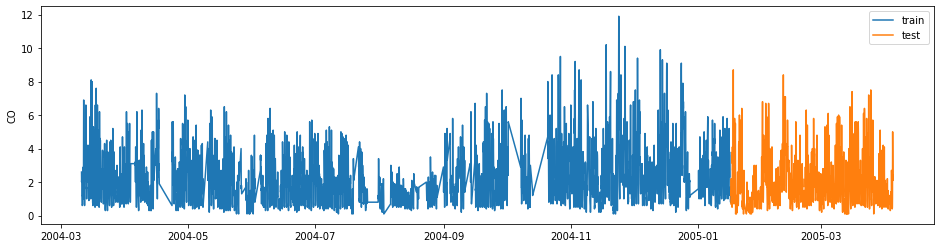

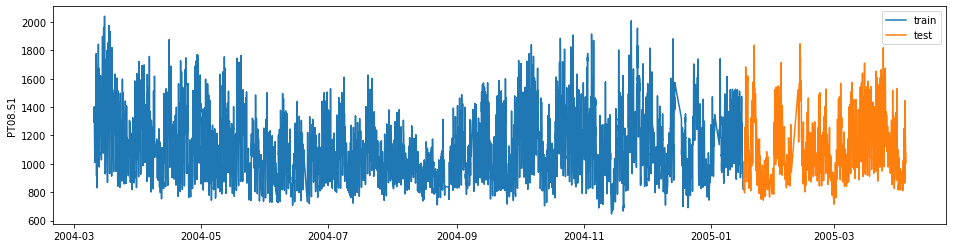

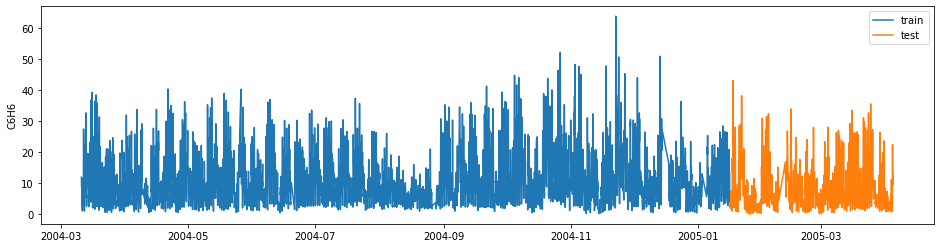

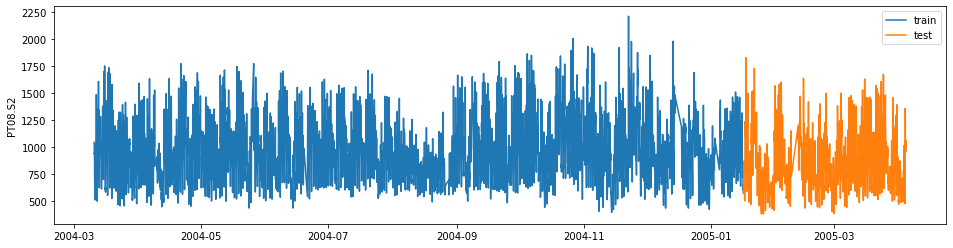

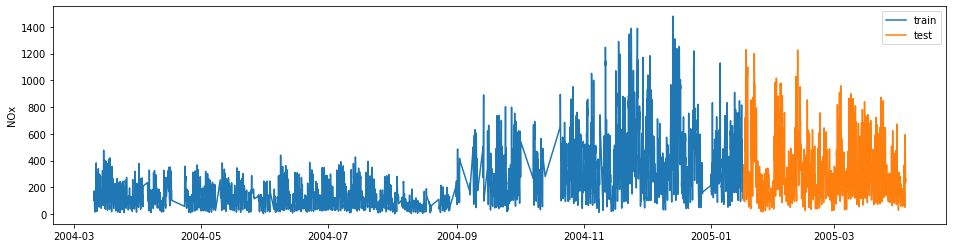

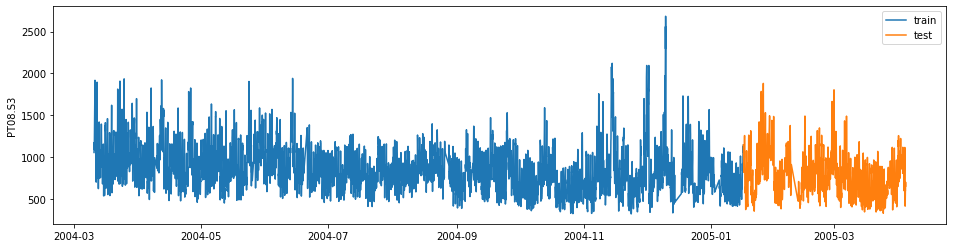

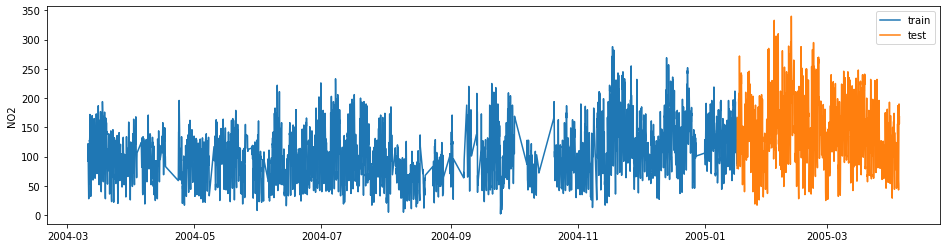

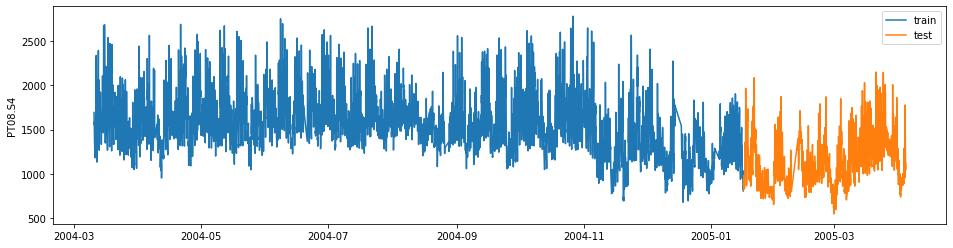

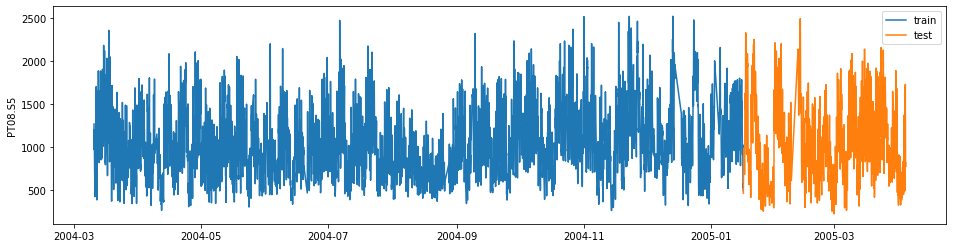

In [24]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

## VAR MODELING

With ARIMA we are using the past values of every variable to make the predictions for the future. When we have multiple time series at our disposal, we can also extract information from their relationships, in this way VAR is a multivariate generalization of ARIMA because it is able to understand and use the relationship between several inputs. This is useful for describing the dynamic behavior of the data and also provides better forecasting results.

To correctly develop a VAR model, the same classical assumptions encountered when fitting an ARIMA, have to be satisfied. We need to grant stationarity and remove autocorrelation behavior. These prerequisites enable us to develop a stable model. Our time series are stationary in mean but locking at autocorrelation plots some interest patterns appear. A periodical weekly pattern is present in all series. To remove them a differentiation is needed (24x7 periods).

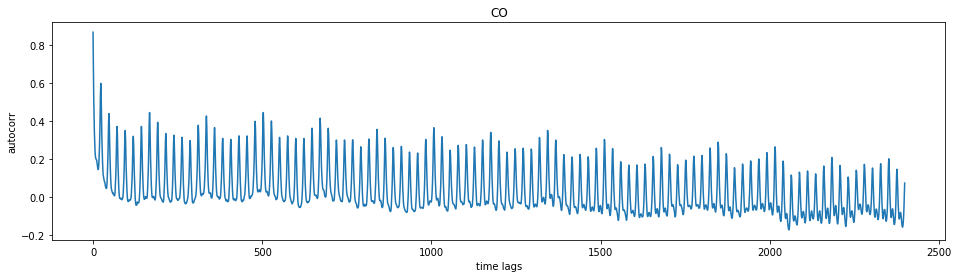

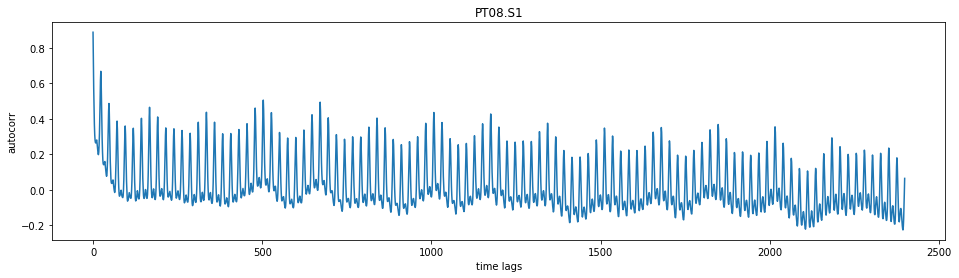

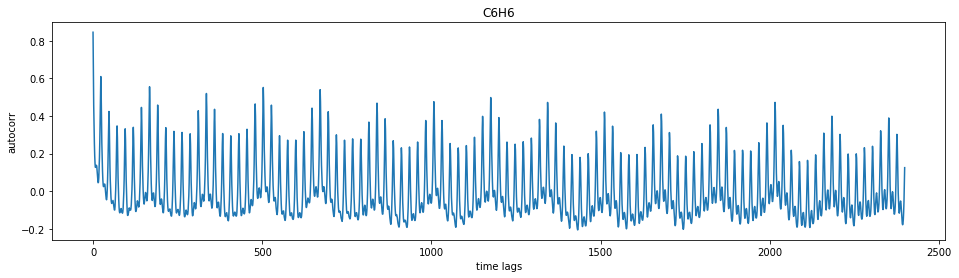

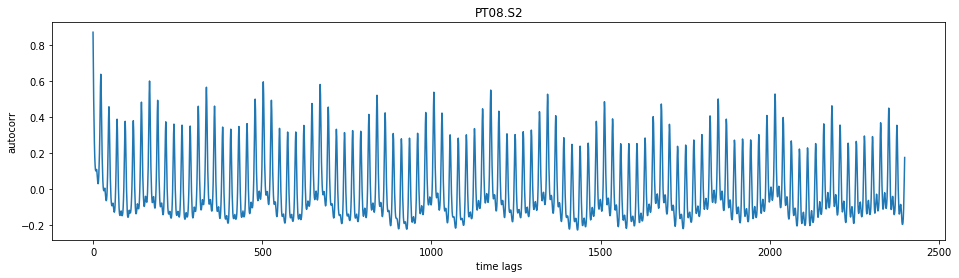

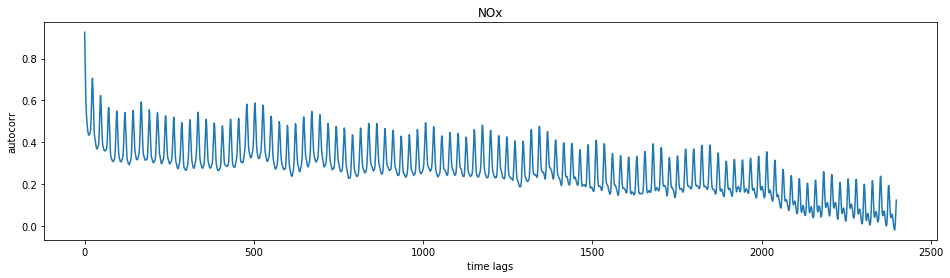

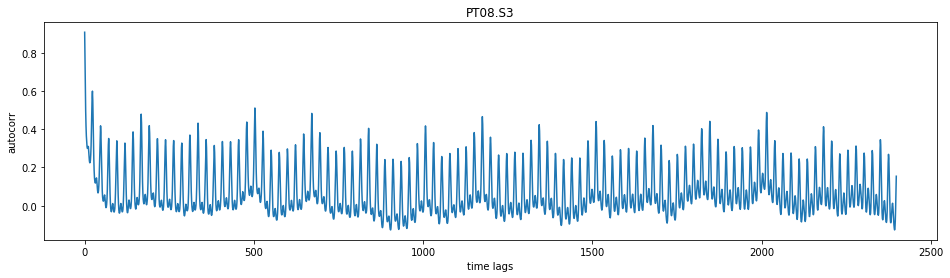

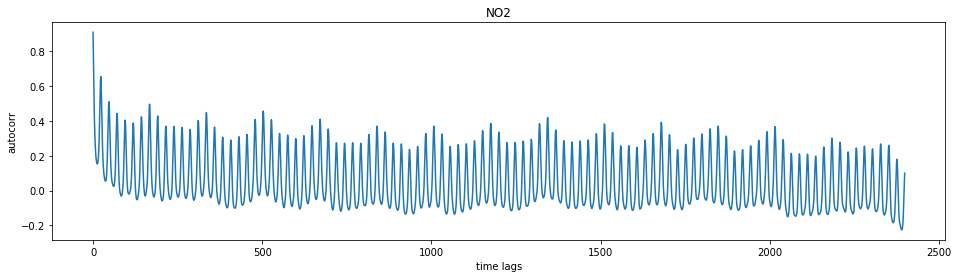

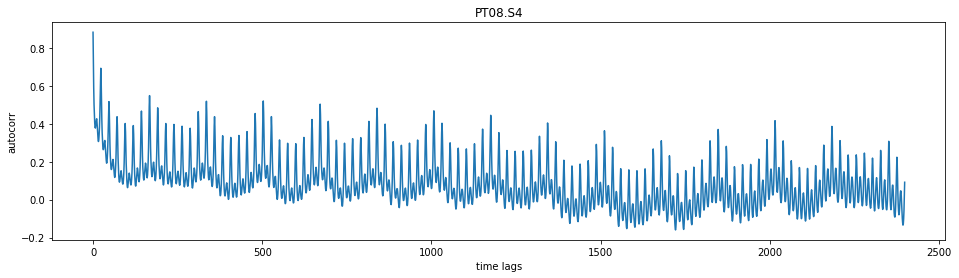

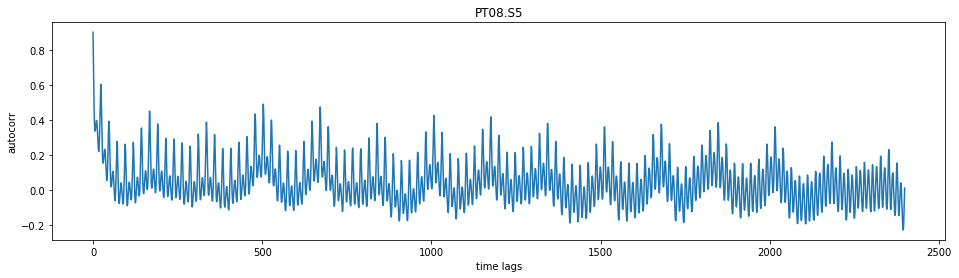

In [25]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

## Autocorrelation plots

In [26]:
### OPERATE DIFFERENTIATION ###

period = 24*7

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()
df_external

T    RH      AH  month_sin     month_cos   day_sin  \
date                                                                         
2004-03-17 18:00:00  25.9  16.0  0.5237   1.000000  6.123234e-17  0.866025   
2004-03-17 19:00:00  23.1  26.5  0.7403   1.000000  6.123234e-17  0.866025   
2004-03-17 20:00:00  20.5  38.2  0.9133   1.000000  6.123234e-17  0.866025   
2004-03-17 21:00:00  19.1  42.6  0.9294   1.000000  6.123234e-17  0.866025   
2004-03-17 22:00:00  17.2  44.1  0.8558   1.000000  6.123234e-17  0.866025   
...                   ...   ...     ...        ...           ...       ...   
2005-04-04 10:00:00  21.9  29.3  0.7568   0.866025 -5.000000e-01  0.000000   
2005-04-04 11:00:00  24.3  23.7  0.7119   0.866025 -5.000000e-01  0.000000   
2005-04-04 12:00:00  26.9  18.3  0.6406   0.866025 -5.000000e-01  0.000000   
2005-04-04 13:00:00  28.3  13.5  0.5139   0.866025 -5.000000e-01  0.000000   
2005-04-04 14:00:00  28.5  13.1  0.5028   0.866025 -5.000000e-01  0.000000   

                     day_cos  hour_sin  hour_cos  
date                                              
2004-03-17 18:00:00     -0.5 -0.979084  0.203456  
2004-03-17 19:00:00     -0.5 -0.887885  0.460065  
2004-03-17 20:00:00     -0.5 -0.730836  0.682553  
2004-03-17 21:00:00     -0.5 -0.519584  0.854419  
2004-03-17 22:00:00     -0.5 -0.269797  0.962917  
...                      ...       ...       ...  
2005-04-04 10:00:00      1.0  0.398401 -0.917211  
2005-04-04 11:00:00      1.0  0.136167 -0.990686  
2005-04-04 12:00:00      1.0 -0.136167 -0.990686  
2005-04-04 13:00:00      1.0 -0.398401 -0.917211  
2005-04-04 14:00:00      1.0 -0.631088 -0.775711  

[9189 rows x 9 columns]

In [27]:
df_diff

CO  PT08.S1  C6H6  PT08.S2    NOx  PT08.S3    NO2  \
date                                                                      
2004-03-17 18:00:00  2.4    197.0  15.1    432.0  133.0   -263.0   45.0   
2004-03-17 19:00:00  5.6    681.0  29.0    782.0  308.0   -557.0  102.0   
2004-03-17 20:00:00  4.5    573.0  26.1    728.0  216.0   -543.0   68.0   
2004-03-17 21:00:00  3.5    419.0  18.0    537.0  164.0   -439.0   58.0   
2004-03-17 22:00:00  1.2    172.0   8.5    314.0   71.0   -435.0   20.0   
...                  ...      ...   ...      ...    ...      ...    ...   
2005-04-04 10:00:00  1.6    203.0   8.3    328.0  256.0   -151.0   75.0   
2005-04-04 11:00:00  0.8     34.0   5.9    239.0  133.0    -88.0   68.0   
2005-04-04 12:00:00  1.0     45.0   8.2    342.0  110.0   -143.0   79.0   
2005-04-04 13:00:00  0.7    -26.0   6.2    291.0   81.0    -98.0   69.0   
2005-04-04 14:00:00  1.0      0.0   7.1    295.0  133.0    -82.0   87.0   

                     PT08.S4  PT08.S5  
date                                   
2004-03-17 18:00:00    289.0    301.0  
2004-03-17 19:00:00    855.0   1334.0  
2004-03-17 20:00:00    861.0   1285.0  
2004-03-17 21:00:00    590.0    847.0  
2004-03-17 22:00:00    237.0    617.0  
...                      ...      ...  
2005-04-04 10:00:00     43.0    814.0  
2005-04-04 11:00:00    -41.0    349.0  
2005-04-04 12:00:00    -25.0    285.0  
2005-04-04 13:00:00   -182.0     92.0  
2005-04-04 14:00:00   -160.0    148.0  

[9189 rows x 9 columns]

In [28]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(7317, 9) (7317, 9) (7317, 9)
(1872, 9) (1872, 9) (1872, 9)


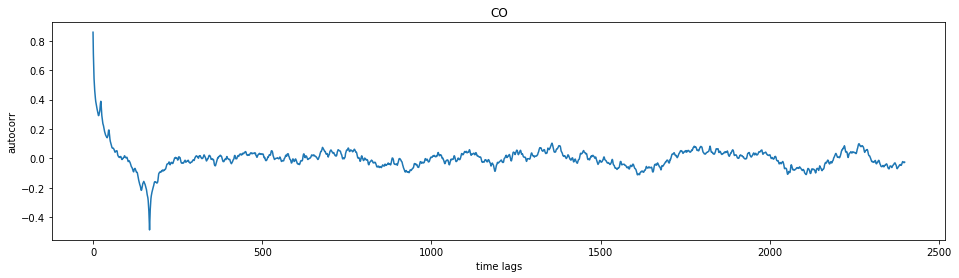

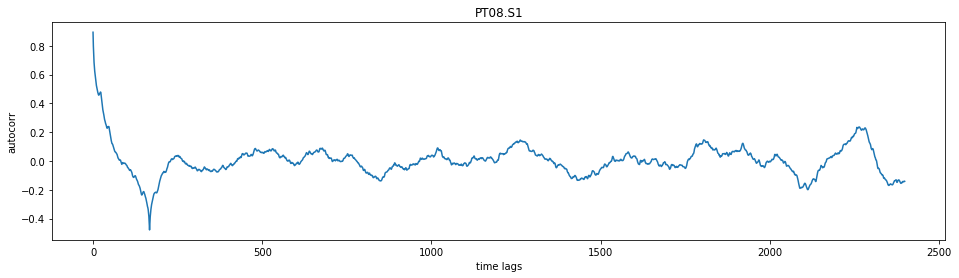

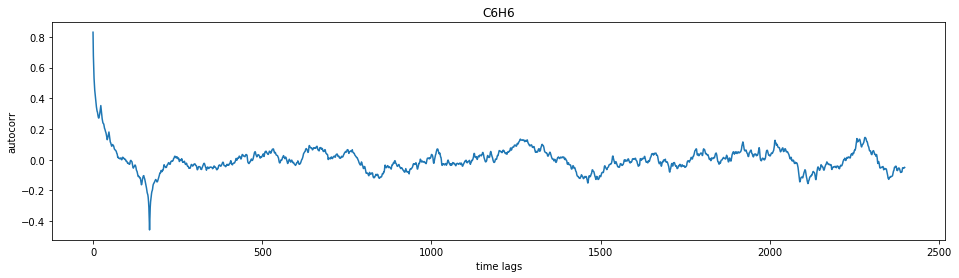

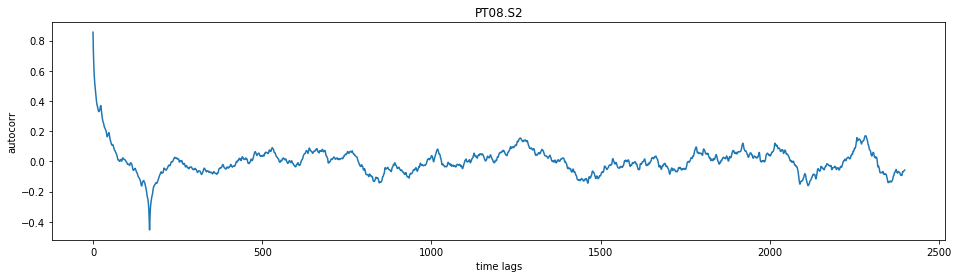

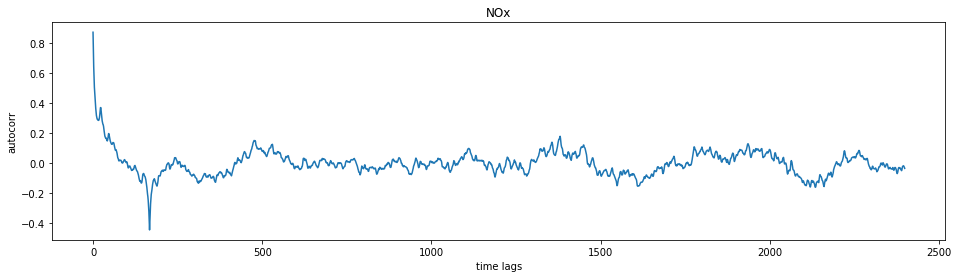

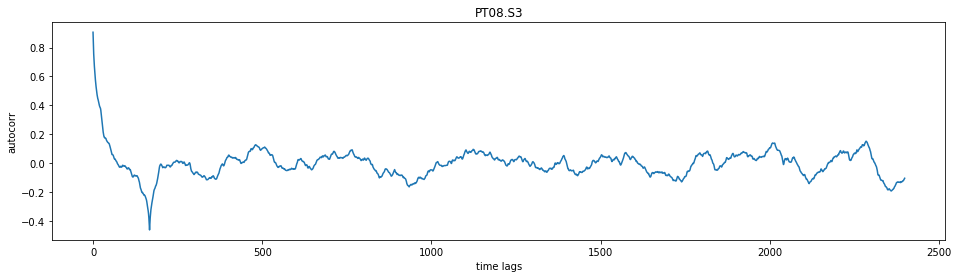

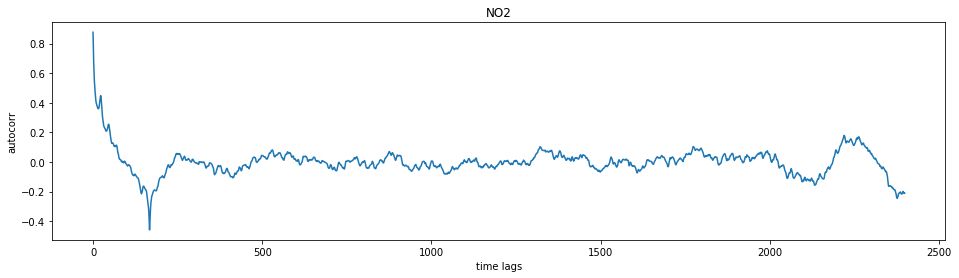

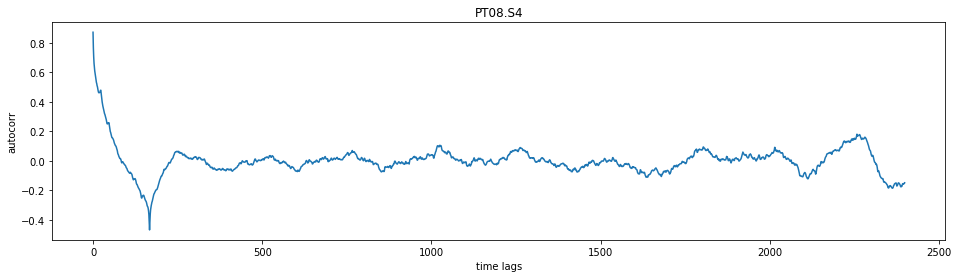

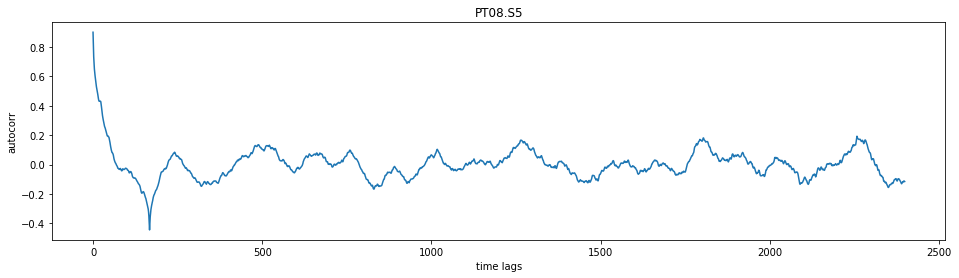

In [29]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

After these preliminary checks, we are ready to fit our VAR. The choice of the perfect lag order is made automatically with the AIC/BIC criterion. We operate the selection with the AIC: all we need to do is recursively fitting our model changing the lag order and annotate the AIC score (the lowest the better). This process can be carried out considering only our train data. In our case, 28 is the best lag order.

In [30]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 28 BEST AIC: 53.23510836989694


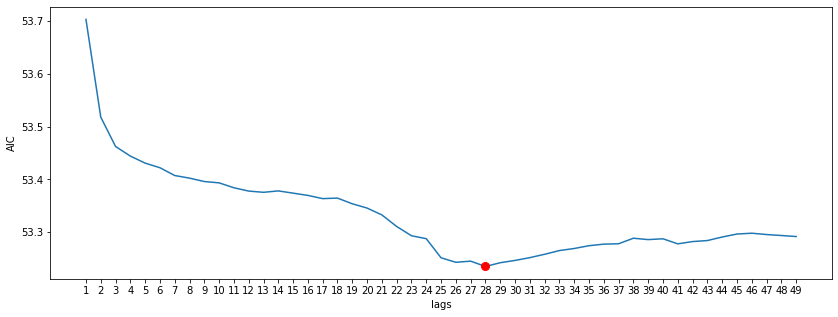

In [31]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [32]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

53.23510836989694

We ended with a well fitted VAR. Remember that it’s trained on the differential data, with 24x7 order of difference. So our model is trained to predict the variations from the previous 24x7 periods, i.e. at 12:00 pm on Monday we are predicting the variations of our series from Monday at 12:00 pm of the previous week. It’s our duty to retrieve the values of predictions in absolute terms. At the moment this is not necessary for our analysis but in the notebook, I also provide a utility function to retrieve the prediction for future data starting from differential data (whatever the order of differentiation).

## VAR LONG-TERM PREDICTION

In [33]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [34]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2005-03-07 14:00:00'
forward = 100
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

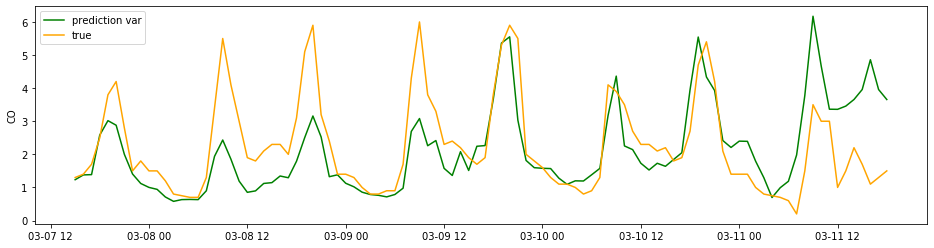

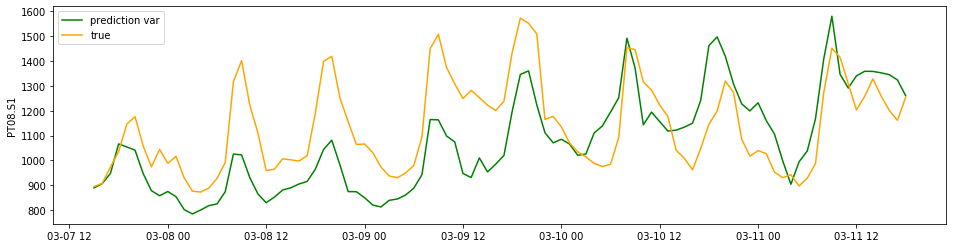

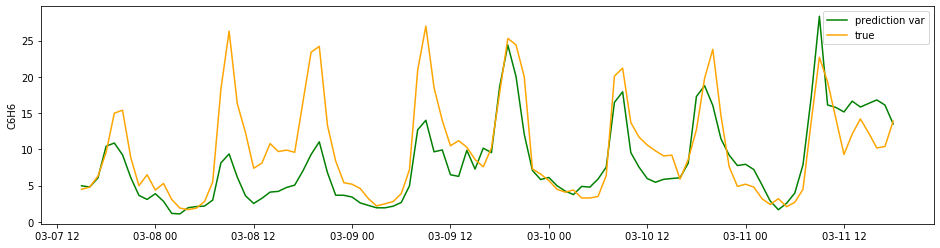

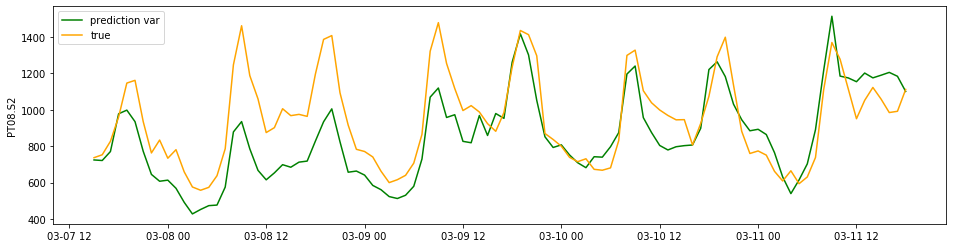

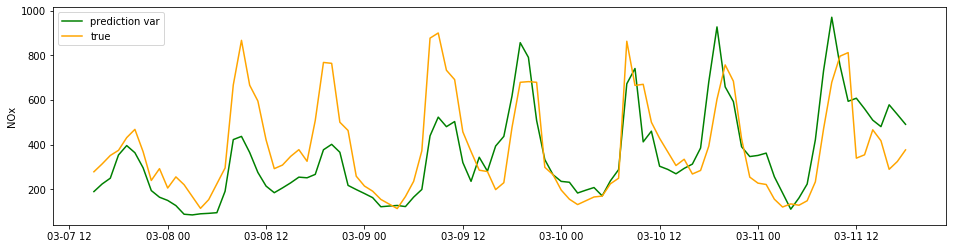

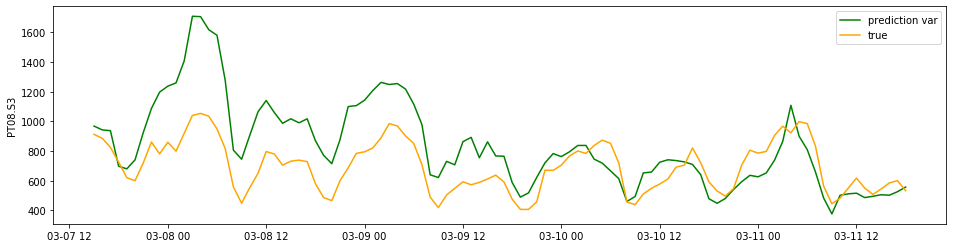

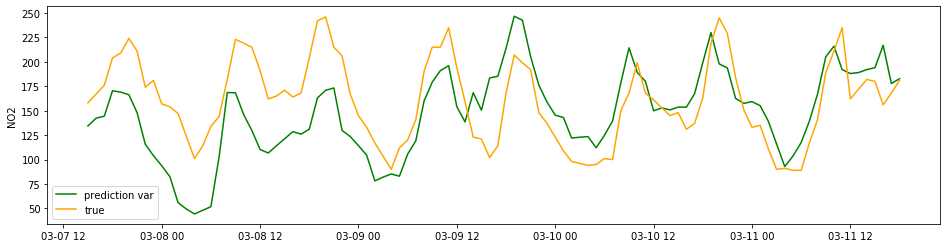

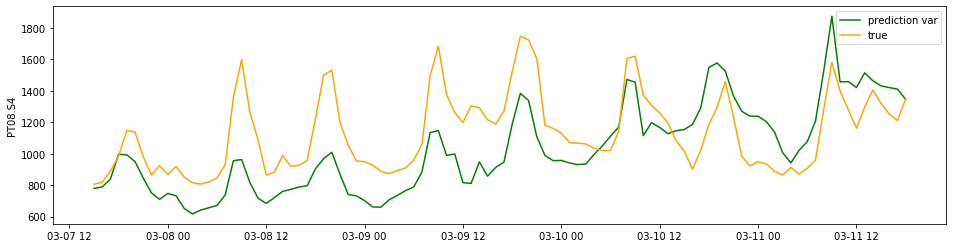

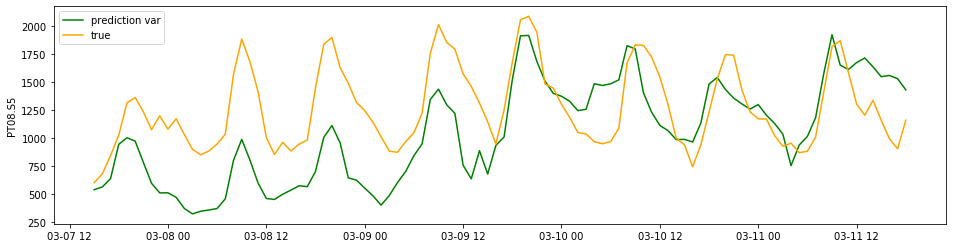

In [35]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

## COMBINE VAR AND LSTM

Now our scope is to use our fitted VAR to improve the training of our neural network. The VAR has learned the internal behavior of our multivariate data source adjusting the insane values, correcting the anomalous trends and reconstructing properly the NaNs. All these pieces of information are stored in the fitted values, they are a modified version of the original data which have been manipulated by the model during the training procedure. In other words, we can see these values as a kind of augmented data source of the original train.

Our strategy involves applying a two-step training procedure. We start feeding our LSTM model, for one step ahead forecasting of all the series at our disposal (multivariate output), using the fitted values produced by VAR. Then we conclude the training with the raw data, in our case they are the same differential data we used before to fit the VAR. With LSTM we can also combine external data sources, for example, the weather conditions or some time attributes like weekdays, hours and months that we cyclically encode.

We hope that our neural network can learn from two different but similar data sources and perform better on our test data. Our approach sounds great but this is not a ‘free lunch’. When performing multiple-steps training we have to take care of the [Catastrophic Forgetting](https://arxiv.org/pdf/1312.6211.pdf) problem. Catastrophic forgetting is a problem faced by many models and algorithms. When trained on one task, then trained on a second task, many machine learning models “forget” how to perform the first task. This is widely believed to be a serious problem for neural networks.

To avoid this tedious problem, the usage of dropout is suggested, moreover, the structure of the entire network has to be properly tuned to provide a benefit in performance terms. From these observations, we preserve a final part of our previous training as validation.
Technically speaking the network is very simple. We adopt the TimeseriesGenerator of Keras to fit our model.

In [36]:

### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 30

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 18))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(9)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [37]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X, train_ext.iloc[best_order:].values], axis=1)

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

In [38]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [39]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

In [40]:
### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 182 steps, validate for 45 steps
Epoch 1/100
182/182 [==============================] - 10s 52ms/step - loss: 0.8990 - val_loss: 1.4180
Epoch 2/100
182/182 [==============================] - 5s 30ms/step - loss: 0.7039 - val_loss: 1.3065
Epoch 3/100
182/182 [==============================] - 5s 27ms/step - loss: 0.6332 - val_loss: 1.2256
Epoch 4/100
182/182 [==============================] - 5s 27ms/step - loss: 0.5829 - val_loss: 1.1319
Epoch 5/100
182/182 [==============================] - 5s 28ms/step - loss: 0.5595 - val_loss: 1.1437
Epoch 6/100
182/182 [==============================] - 5s 27ms/step - loss: 0.5293 - val_loss: 1.1652
Epoch 7/100
182/182 [==============================] - 5s 27ms/step - loss: 0.5157 - val_loss: 1.1189
Epoch 8/100
182/182 [==============================] - 5s 28ms/

In [41]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

Instructions for updating:
Please use Model.predict, which supports generators.


In [42]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 182 steps, validate for 45 steps
Epoch 1/100
182/182 [==============================] - 8s 44ms/step - loss: 0.8798 - val_loss: 1.3398
Epoch 2/100
182/182 [==============================] - 5s 27ms/step - loss: 0.6665 - val_loss: 1.3011
Epoch 3/100
182/182 [==============================] - 6s 33ms/step - loss: 0.5914 - val_loss: 1.1993
Epoch 4/100
182/182 [==============================] - 5s 28ms/step - loss: 0.5475 - val_loss: 1.1195
Epoch 5/100
182/182 [==============================] - 5s 28ms/step - loss: 0.5164 - val_loss: 1.0454
Epoch 6/100
182/182 [==============================] - 5s 27ms/step - loss: 0.4948 - val_loss: 1.0691
Epoch 7/100
182/182 [==============================] - 5s 28ms/step - loss: 0.4767 - val_loss: 1.0737
Epoch 8/100
182/182 [==============================] - 5s 28ms/step - loss: 0.4448 - val_loss: 0.9885
Epoch 9/100
182/182 [==============================] - 5s 29ms/step - loss: 0.4331 - val_lo

In [43]:
### OBTAIN PREDICTIONS ###

pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)

In [44]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

In the end, we can compare the model trained on the fitted values of the VAR plus the original data and the same structure trained only on the original training data. The errors, in form of MAE, for our output series are lower when we perform the two training steps, preserving at the same time the correlation of reality and prediction, with 1 lag of delay, under 80% (this procedure is a good practice to verify if the predictions of the future are not the present values repeated, i.e. not a useful prediction).

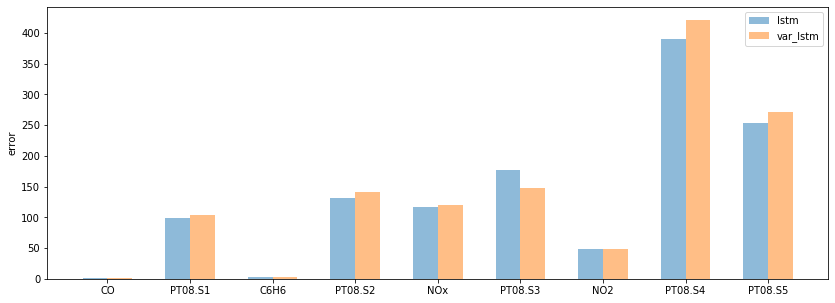

In [45]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

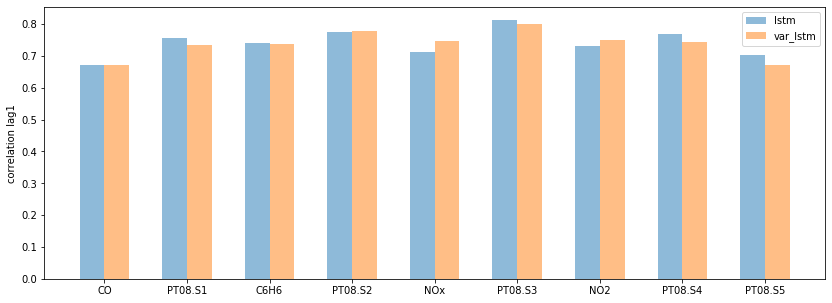

In [46]:

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)

## SUMMARY

In this post, I try to use the information learned by a VAR model, for a multivariate time series task, to improve the performance of a recurrent neural network trained to predict the future. We operate a two-step training procedure, fighting the problem of Catastrophic Forgetting and achieving an improvement in the overall performances.